In [33]:
# Install required libraries
%pip install seaborn torch torchvision scikit-learn pillow matplotlib


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [34]:
# Import Required Libraries
import os
import numpy as np
import seaborn as sns
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from PIL import ImageFile
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
# Allow Loading Truncated Images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [37]:
# Define Dataset Directories
base_dir = '/Users/kaan/Documents/coding/bone_fracture'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

In [38]:
# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to 150x150
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Randomly rotate images by 10 degrees
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

In [39]:
# Load Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

In [40]:
# Define Data Loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [41]:
# Show Data Counts
train_count = len(train_dataset)
val_count = len(val_dataset)
test_count = len(test_dataset)

print(f'Training Data Count: {train_count}')
print(f'Validation Data Count: {val_count}')
print(f'Test Data Count: {test_count}')

Training Data Count: 9246
Validation Data Count: 829
Test Data Count: 506


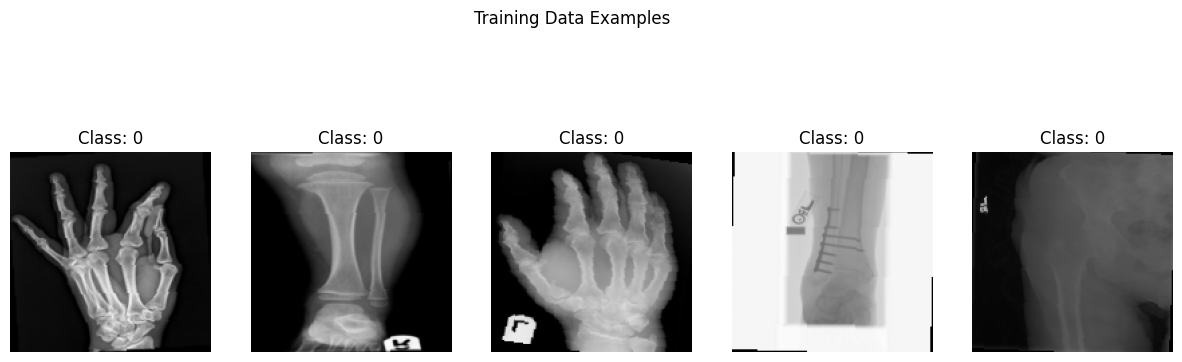

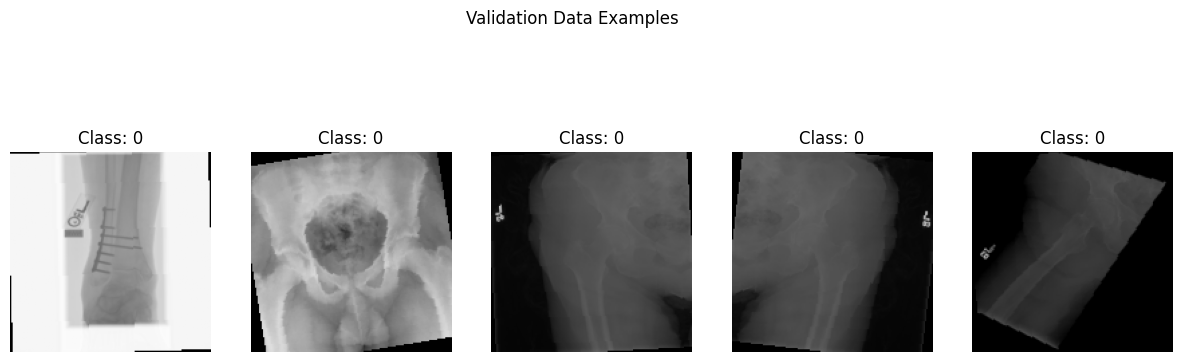

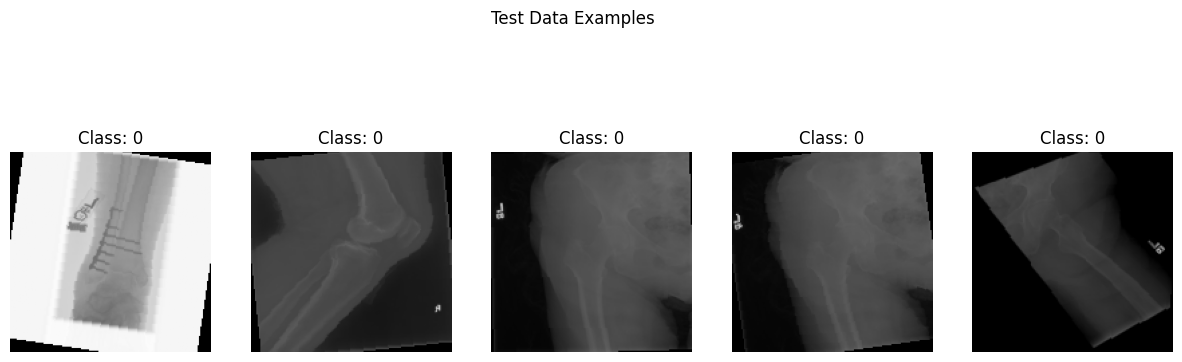

In [42]:
# Show Sample Images
def show_images(dataset, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    fig.suptitle(title)
    for i, (image, label) in enumerate(dataset):
        if i >= 5:
            break
        image = image * 0.5 + 0.5  # Denormalize the image
        npimg = image.numpy()
        axes[i].imshow(np.transpose(npimg, (1, 2, 0)))
        axes[i].set_title(f'Class: {label}')
        axes[i].axis('off')
    plt.show()

show_images(train_dataset, 'Training Data Examples')
show_images(val_dataset, 'Validation Data Examples')
show_images(test_dataset, 'Test Data Examples')

/var/folders/sg/2z4_wvx141z4htw038m8swnr0000gn/T/ipykernel_96705/939102049.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=dataset.classes, y=class_counts, palette="viridis")  # Renk skalası ekledik


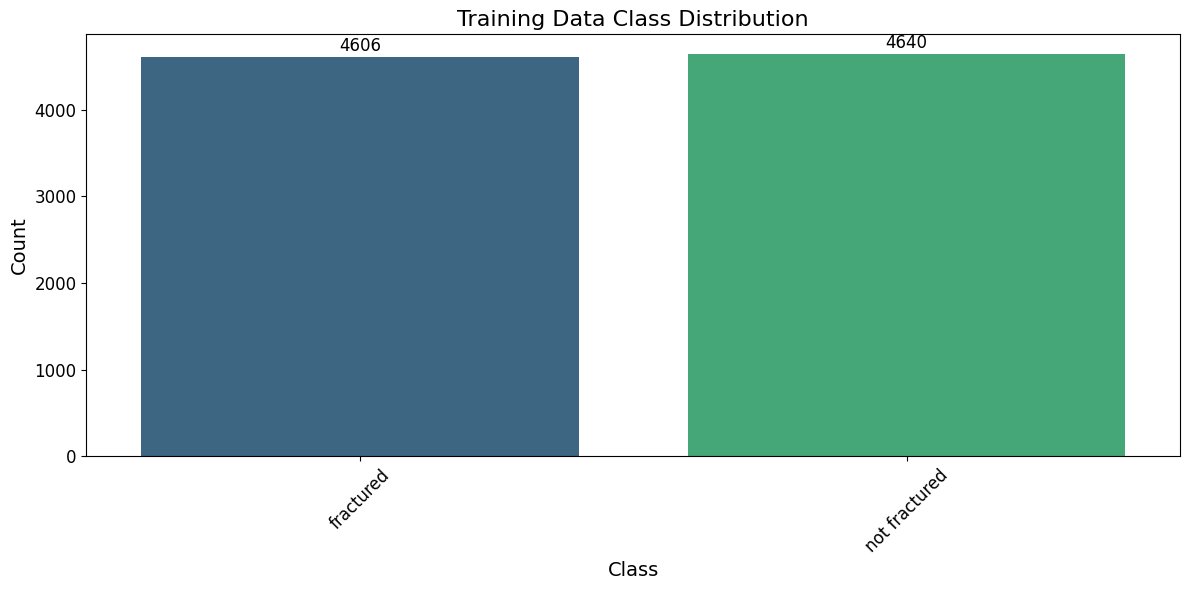

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/var/folders/sg/2z4_wvx141z4htw038m8swnr0000gn/T/ipykernel_96705/939102049.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=dataset.classes, y=class_counts, palette="viridis")  # Renk skalası ekledik


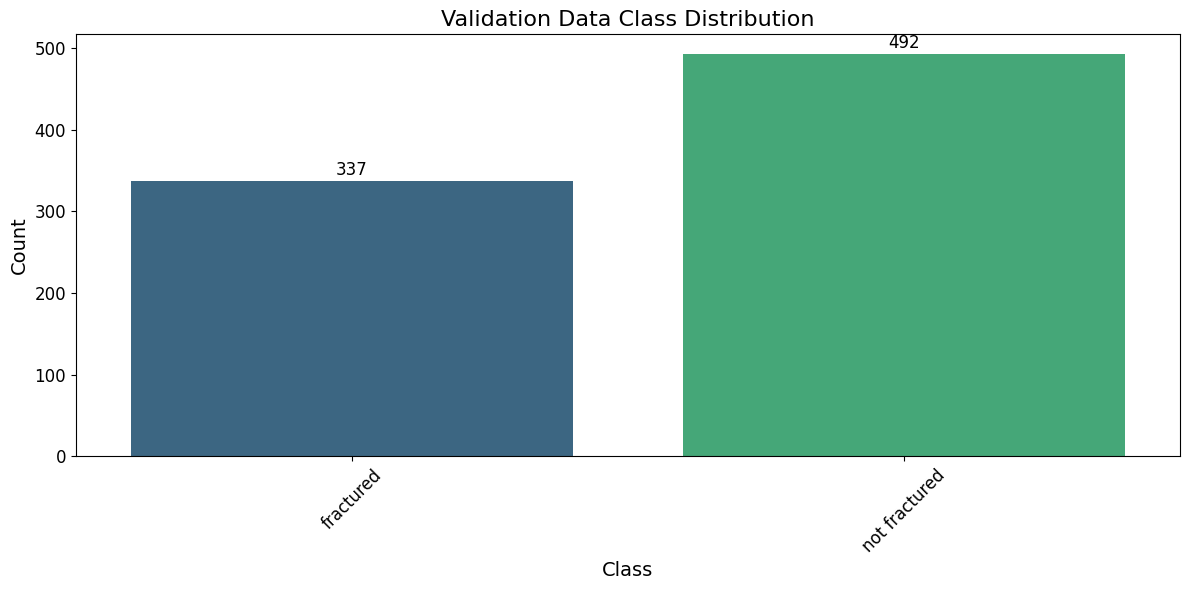

/var/folders/sg/2z4_wvx141z4htw038m8swnr0000gn/T/ipykernel_96705/939102049.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=dataset.classes, y=class_counts, palette="viridis")  # Renk skalası ekledik


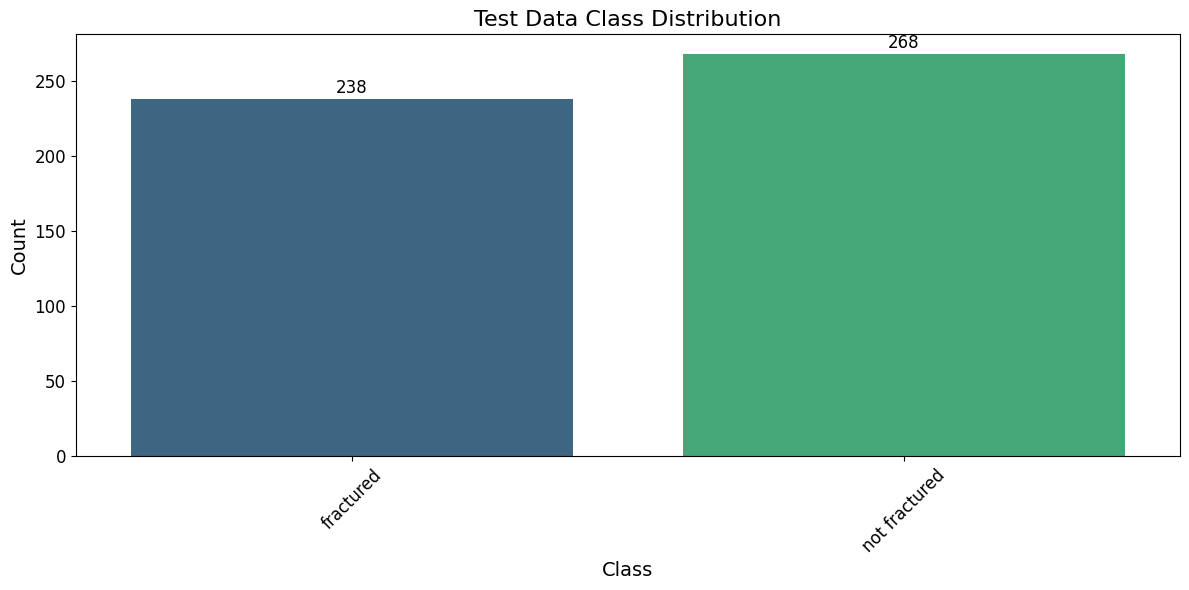

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(dataset, title):
    class_counts = [0] * len(dataset.classes)
    for _, label in dataset:
        class_counts[label] += 1
    
    plt.figure(figsize=(12, 6))  # Daha geniş bir grafik boyutu
    ax = sns.barplot(x=dataset.classes, y=class_counts, palette="viridis")  # Renk skalası ekledik
    plt.title(title, fontsize=16)
    plt.ylabel('Count', fontsize=14)
    plt.xlabel('Class', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Her sütunun üstüne sayısal değer eklemek
    for i, count in enumerate(class_counts):
        ax.text(i, count + max(class_counts) * 0.005,  # Sayıyı biraz yukarı konumlandır
                str(count), ha='center', va='bottom', fontsize=12, color='black')
    
    plt.tight_layout()  # Grafik kenarlarını düzenler
    plt.show()

plot_class_distribution(train_dataset, 'Training Data Class Distribution')
plot_class_distribution(val_dataset, 'Validation Data Class Distribution')
plot_class_distribution(test_dataset, 'Test Data Class Distribution')

In [44]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.fc1 = nn.Linear(64 * 37 * 37, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 1)  # Second fully connected layer
        self.dropout = nn.Dropout(0.5)  # Dropout layer

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Apply first convolution and pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Apply second convolution and pooling
        x = x.view(-1, self.num_flat_features(x))  # Flatten the tensor
        x = torch.relu(self.fc1(x))  # Apply first fully connected layer
        x = self.dropout(x)  # Apply dropout
        x = torch.sigmoid(self.fc2(x))  # Apply second fully connected layer and sigmoid activation
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # Exclude batch size
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [45]:
# Define Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
model = CNNModel().to(device)  # Instantiate the CNN model and move it to the device (GPU or CPU)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate of 0.001

In [46]:
for epoch in range(10):  # Train for 10 epochs
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss
    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
        outputs = model(images)  # Forward pass
        loss = criterion(outputs.view(-1), labels.float())  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        running_loss += loss.item()  # Update running loss
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')  # Print epoch loss

Epoch 1, Loss: 0.4490
Epoch 2, Loss: 0.1516
Epoch 3, Loss: 0.0903
Epoch 4, Loss: 0.0701
Epoch 5, Loss: 0.0426
Epoch 6, Loss: 0.0379
Epoch 7, Loss: 0.0329
Epoch 8, Loss: 0.0319
Epoch 9, Loss: 0.0311
Epoch 10, Loss: 0.0292


In [47]:
# Validate the Model
model.eval()  # Set the model to evaluation mode
val_labels = []  # List to store validation labels
val_preds = []  # List to store validation predictions
with torch.no_grad():  # Disable gradient calculation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
        outputs = model(images)  # Forward pass
        val_preds.extend(outputs.view(-1).cpu().numpy())  # Store predictions
        val_labels.extend(labels.cpu().numpy())  # Store labels

val_preds = (np.array(val_preds) > 0.5).astype(int)  # Convert predictions to binary
accuracy = accuracy_score(val_labels, val_preds)  # Calculate accuracy
print(f'Validation Accuracy: {accuracy:.4f}')  # Print accuracy
print(classification_report(val_labels, val_preds))  # Print classification report

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Accuracy: 0.9638
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       337
           1       0.98      0.96      0.97       492

    accuracy                           0.96       829
   macro avg       0.96      0.96      0.96       829
weighted avg       0.96      0.96      0.96       829



In [48]:
# Prepare Data for Machine Learning Models
X_train = np.array([np.array(image[0]).flatten() for image in train_dataset])  # Flatten training images
y_train = np.array([image[1] for image in train_dataset])  # Get training labels
X_val = np.array([np.array(image[0]).flatten() for image in val_dataset])  # Flatten validation images
y_val = np.array([image[1] for image in val_dataset])  # Get validation labels

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform training data
X_val = scaler.transform(X_val)  # Transform validation data

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [49]:
# Train and Evaluate Machine Learning Models
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
}

results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)  # Train the model
    y_pred = clf.predict(X_val)  # Predict on validation data
    accuracy = accuracy_score(y_val, y_pred)  # Calculate accuracy
    results[name] = accuracy  # Store the results
    print(f'{name} Accuracy: {accuracy}')  # Print accuracy
    print(classification_report(y_val, y_pred))  # Print classification report


Logistic Regression Accuracy: 0.7889022919179735
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       337
           1       0.82      0.82      0.82       492

    accuracy                           0.79       829
   macro avg       0.78      0.78      0.78       829
weighted avg       0.79      0.79      0.79       829

Decision Tree Accuracy: 0.8854041013268998
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       337
           1       0.89      0.92      0.90       492

    accuracy                           0.89       829
   macro avg       0.88      0.88      0.88       829
weighted avg       0.89      0.89      0.89       829

Random Forest Accuracy: 0.9674306393244874
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       337
           1       0.97      0.97      0.97       492

    accuracy                           0.97    

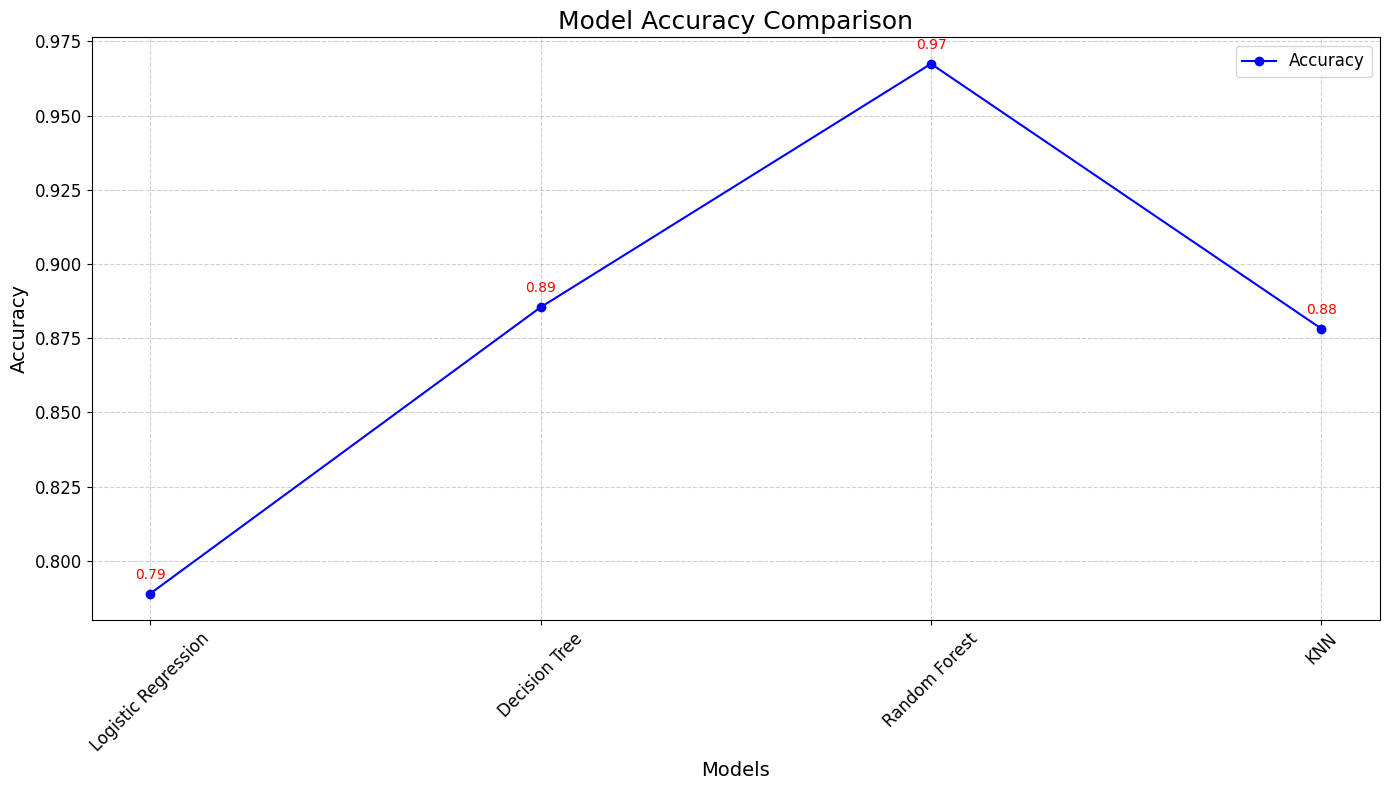

In [55]:
import matplotlib.pyplot as plt

# Örnek results verisi
# results = {'Model A': 0.85, 'Model B': 0.78, 'Model C': 0.92, 'Model D': 0.88}

def plot_line_chart_with_values(results, title):
    models = list(results.keys())
    accuracies = list(results.values())
    
    plt.figure(figsize=(14, 8))  # Daha büyük bir grafik boyutu
    plt.plot(models, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')  # Çizgi grafiği
    plt.title(title, fontsize=18, color='black')  # Başlık kırmızı
    plt.ylabel('Accuracy', fontsize=14, color='black')  # Y-eksen yazısı kırmızı
    plt.xlabel('Models', fontsize=14, color='black')  # X-eksen yazısı kırmızı
    plt.xticks(rotation=45, fontsize=12, color='black')  # X-eksen değerleri kırmızı
    plt.yticks(fontsize=12, color='black')  # Y-eksen değerleri kırmızı
    
    # Noktaların üzerine değer ekleme, siyah renk ile
    for i, accuracy in enumerate(accuracies):
        plt.text(i, accuracy + 0.004, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10, color='red')  # Nokta yazıları siyah
    
    plt.tight_layout()
    plt.grid(visible=True, linestyle='--', alpha=0.6)  # Arka plana grid çizgileri ekleme
    plt.legend(fontsize=12)
    plt.show()

plot_line_chart_with_values(results, 'Model Accuracy Comparison')

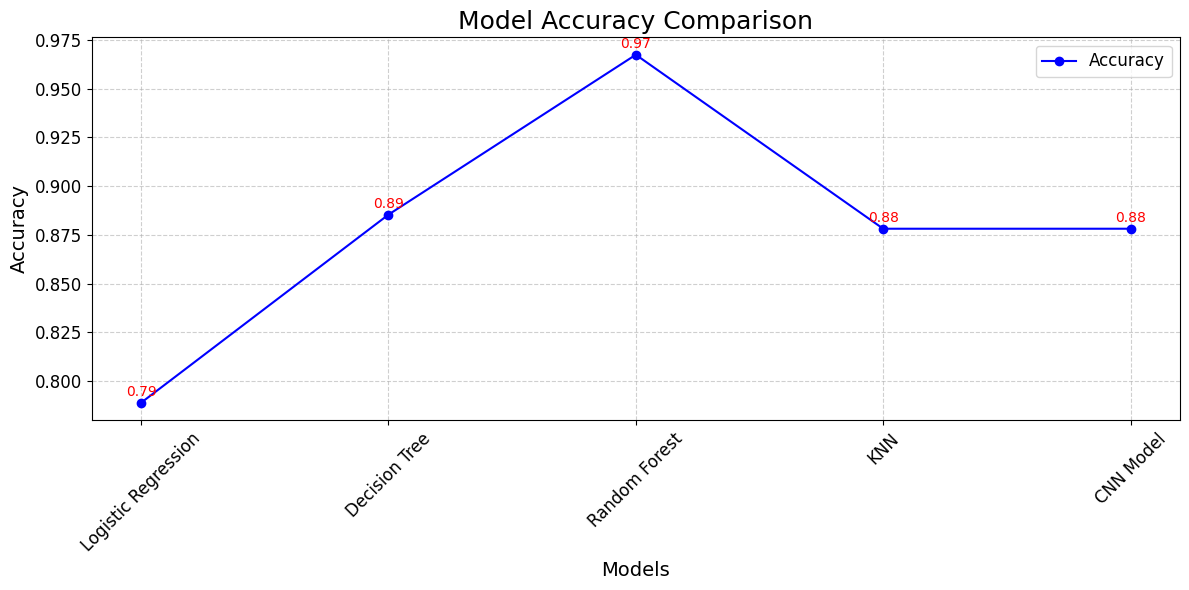

In [56]:
import matplotlib.pyplot as plt

# Örnek `results` ve `accuracy` verileri
# results = {'Model A': 0.85, 'Model B': 0.78, 'Model C': 0.92}
# accuracy = 0.88

# `all_results` birleştirme
all_results = {**results, 'CNN Model': accuracy}

def plot_line_chart_with_values(all_results, title):
    models = list(all_results.keys())
    accuracies = list(all_results.values())
    
    plt.figure(figsize=(12, 6))  # Daha büyük bir grafik boyutu
    plt.plot(models, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')  # Çizgi grafiği
    plt.title(title, fontsize=18, color='black')  # Başlık kırmızı
    plt.ylabel('Accuracy', fontsize=14, color='black')  # Y-eksen yazısı kırmızı
    plt.xlabel('Models', fontsize=14, color='black')  # X-eksen yazısı kırmızı
    plt.xticks(rotation=45, fontsize=12, color='black')  # X-eksen değerleri kırmızı
    plt.yticks(fontsize=12, color='black')  # Y-eksen değerleri kırmızı
    
    # Noktaların üzerine değer ekleme, siyah renk ile
    for i, accuracy in enumerate(accuracies):
        plt.text(i, accuracy + 0.002, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10, color='red')  # Nokta yazıları siyah
    
    plt.tight_layout()
    plt.grid(visible=True, linestyle='--', alpha=0.6)  # Arka plana grid çizgileri ekleme
    plt.legend(fontsize=12)
    plt.show()

plot_line_chart_with_values(all_results, 'Model Accuracy Comparison')